In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import datetime

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier

from astroML.utils import completeness_contamination

import tensorflow as tf
from tensorflow import keras

import keras_tuner

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[6,5]

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
data=pd.read_csv('galaxyquasar.csv')

#let's have a look at the data
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [11]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

# 0=QSO 1=Galaxy

label=np.array(data['class'])
label=np.array(label=='GALAXY', dtype=int)

colors=['u-g', 'g-r', 'r-i', 'i-z']

In [51]:
#splitting the dataset

X=np.array([u_g,g_r,r_i,i_z]).T

scaler = StandardScaler()
X_s=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_s, label, test_size=0.3, random_state=1)

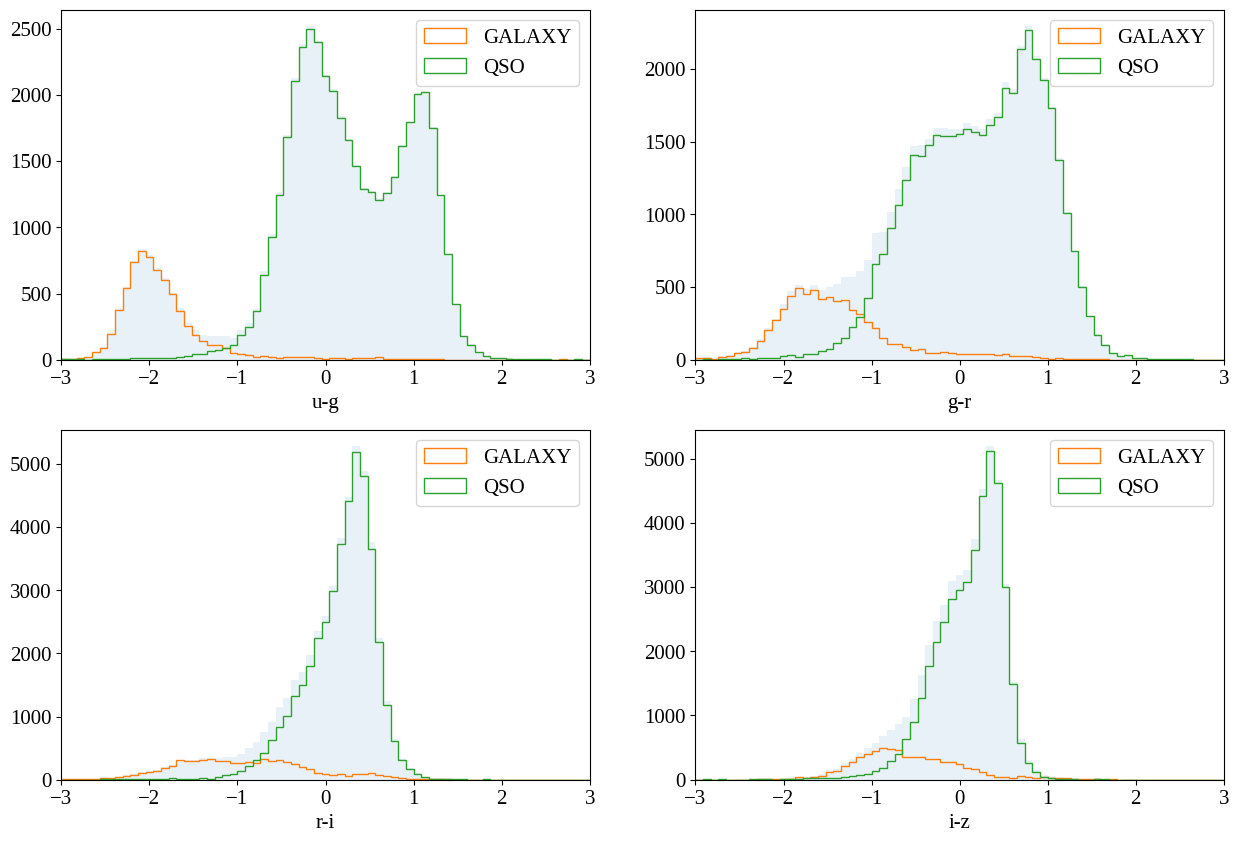

In [13]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(X_s))):
    a.hist(X_s[:,i], bins=bins, alpha=0.1)
    a.hist(X_s[:,i][label==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X_s[:,i][label==1], bins=bins, histtype='step', lw=1, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

In [14]:
def trainnetwork(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model


def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

In [15]:
trainnetwork(X_train, X_test, y_train, y_test, filename='gal_QSO_trained.h5')

In [16]:
model = loadnetwork('gal_QSO_trained.h5')

In [17]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

469/469 - 0s - loss: 0.0670 - accuracy: 0.9823 - 434ms/epoch - 926us/step

Test accuracy: 0.9822666645050049


In [18]:
train_pred = np.squeeze((model.predict(X_train) > 0.5).astype("int32"))
test_pred = np.squeeze((model.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 512us/step


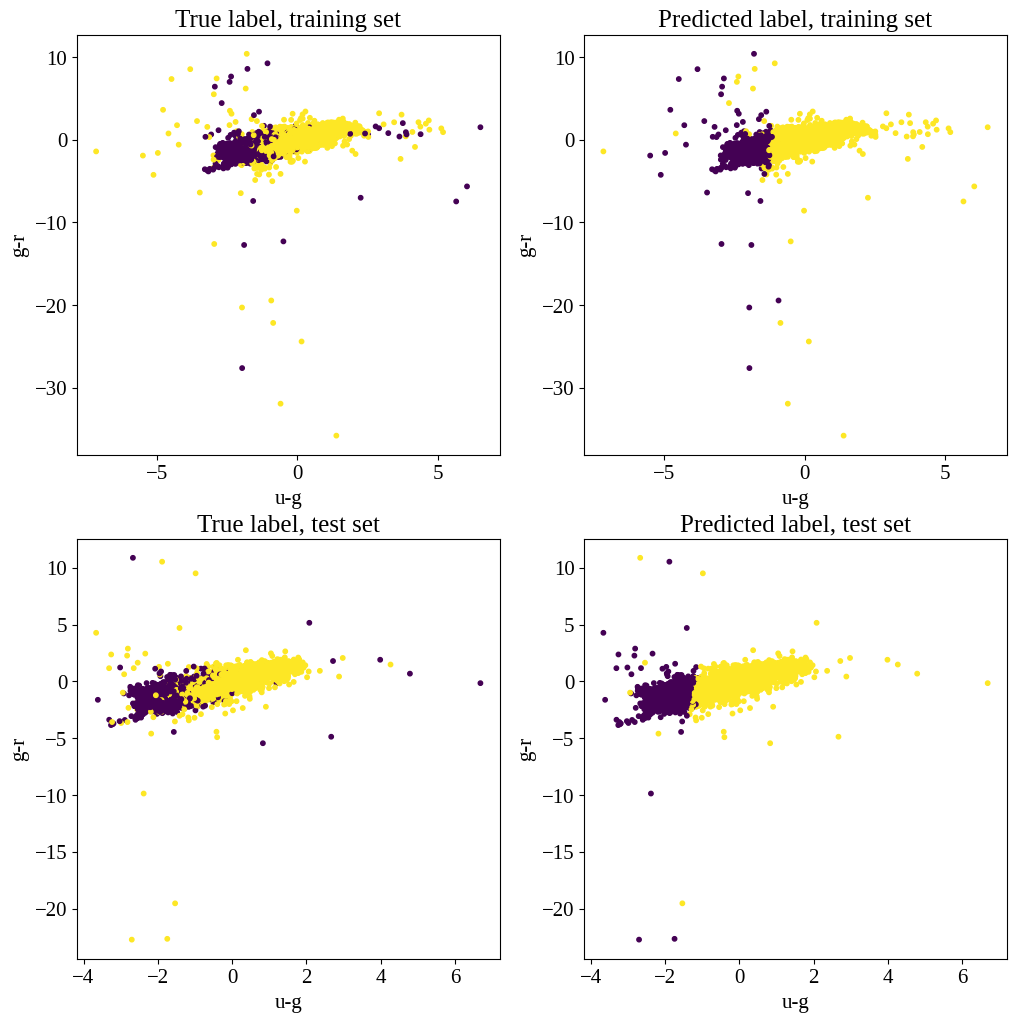

In [19]:
s=10

fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_train[:,0], X_train[:,1], c=train_pred, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('True label, test set')


ax=fig.add_subplot(224)
plt.scatter(X_test[:,0], X_test[:,1], c=test_pred, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.title('Predicted label, test set')


plt.show()

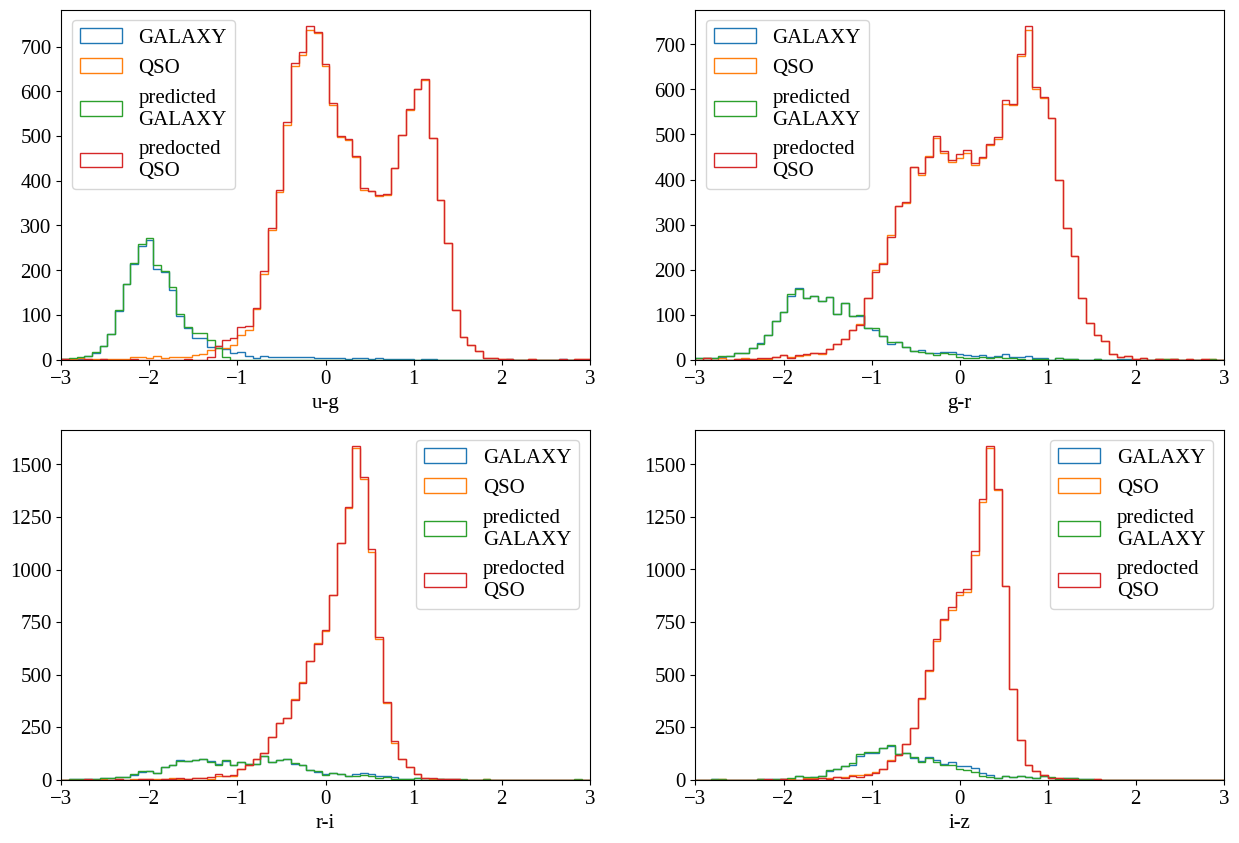

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(X_s))):
    a.hist(X_test[:,i][y_test==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X_test[:,i][y_test==1], bins=bins, histtype='step', lw=1, label='QSO')
    a.hist(X_test[:,i][test_pred==0], bins=bins, histtype='step', lw=1, label='predicted\nGALAXY')
    a.hist(X_test[:,i][test_pred==1], bins=bins, histtype='step', lw=1, label='predocted\nQSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

In [76]:
accuracy_train = accuracy_score(y_train, train_pred)
accuracy_test = accuracy_score(y_test, test_pred)

print('The accuracy of the training set is:', round(accuracy_train,3))
print('The accuracy of the test set is:', round(accuracy_test,3))

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

print('\n Confusion matrix of the training set: \n',  cm_train)
print('\n Confusion matrix of the test set: \n',  cm_test)

completeness, contamination = completeness_contamination(test_pred, y_test)

print("\ncompleteness", round(float(completeness),3))
print("contamination", round(float(contamination),3))

The accuracy of the training set is: 0.982
The accuracy of the test set is: 0.982

 Confusion matrix of the training set: 
 [[ 4541   429]
 [  212 29818]]

 Confusion matrix of the test set: 
 [[ 2005   159]
 [  107 12729]]

completeness 0.992
contamination 0.012


In [22]:
%tensorboard --logdir logs/fit

469/469 [==============================] - 0s 643us/step


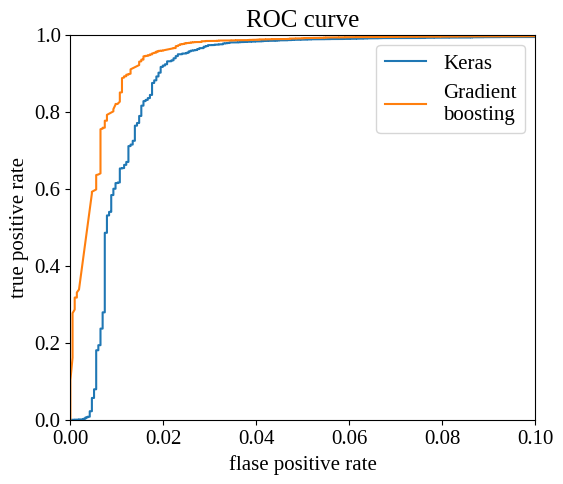

In [23]:
#plt the ROC curve

probs=model.predict(X_test)

gradboost = GradientBoostingClassifier()
gradboost.fit(X_train,y_train)
probs_1 = gradboost.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fpr1, tpr1, thresholds1 = roc_curve(y_test, probs_1)

plt.plot(fpr, tpr, label='Keras')
plt.plot(fpr1, tpr1, label='Gradient\nboosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend()
plt.show()

#we can do better

In [24]:
pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(4,)))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value=4, max_value=36, step=4)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [59]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [60]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 25 Complete [00h 00m 08s]
val_accuracy: 0.9818571209907532

Best val_accuracy So Far: 0.9838571548461914
Total elapsed time: 00h 01m 30s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 16 and the optimal learning rate for the optimizer
is 0.01.



In [61]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
875/875 [==============================] - 1s 928us/step - loss: 0.0890 - accuracy: 0.9796 - val_loss: 0.1013 - val_accuracy: 0.9834
Epoch 2/50
875/875 [==============================] - 1s 909us/step - loss: 0.0789 - accuracy: 0.9823 - val_loss: 0.0680 - val_accuracy: 0.9833
Epoch 3/50
875/875 [==============================] - 1s 978us/step - loss: 0.0707 - accuracy: 0.9827 - val_loss: 0.0665 - val_accuracy: 0.9833
Epoch 4/50
875/875 [==============================] - 1s 880us/step - loss: 0.0726 - accuracy: 0.9831 - val_loss: 0.0911 - val_accuracy: 0.9839
Epoch 5/50
875/875 [==============================] - 1s 882us/step - loss: 0.0715 - accuracy: 0.9836 - val_loss: 0.0969 - val_accuracy: 0.9821
Epoch 6/50
875/875 [==============================] - 1s 870us/step - loss: 0.0699 - accuracy: 0.9836 - val_loss: 0.0948 - val_accuracy: 0.9811
Epoch 7/50
875/875 [==============================] - 1s 816us/step - loss: 0.0697 - accuracy: 0.9835 - val_loss: 0.0842 - val_accuracy:

In [62]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/35
875/875 [==============================] - 1s 933us/step - loss: 0.1013 - accuracy: 0.9765 - val_loss: 0.0797 - val_accuracy: 0.9824
Epoch 2/35
875/875 [==============================] - 1s 831us/step - loss: 0.0743 - accuracy: 0.9823 - val_loss: 0.0701 - val_accuracy: 0.9840
Epoch 3/35
875/875 [==============================] - 1s 824us/step - loss: 0.0745 - accuracy: 0.9824 - val_loss: 0.0949 - val_accuracy: 0.9800
Epoch 4/35
875/875 [==============================] - 1s 947us/step - loss: 0.0682 - accuracy: 0.9839 - val_loss: 0.0727 - val_accuracy: 0.9839
Epoch 5/35
875/875 [==============================] - 1s 921us/step - loss: 0.0715 - accuracy: 0.9834 - val_loss: 0.0655 - val_accuracy: 0.9833
Epoch 6/35
875/875 [==============================] - 1s 833us/step - loss: 0.0654 - accuracy: 0.9839 - val_loss: 0.0770 - val_accuracy: 0.9834
Epoch 7/35
875/875 [==============================] - 1s 912us/step - loss: 0.0695 - accuracy: 0.9840 - val_loss: 0.0774 - val_accuracy:

In [63]:
train_pred_best = np.squeeze((hypermodel.predict(X_train) > 0.5).astype("int32"))
test_pred_best = np.squeeze((hypermodel.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 530us/step


In [77]:
accuracy_train_best = accuracy_score(y_train, train_pred_best)
accuracy_test_best = accuracy_score(y_test, test_pred_best)

print('The accuracy of the training set is:', round(accuracy_train_best,3))
print('The accuracy of the test set is:', round(accuracy_test_best,3))

cm_train_best = confusion_matrix(y_train, train_pred_best)
cm_test_best = confusion_matrix(y_test, test_pred_best)

print('\n Confusion matrix of the training set: \n',  cm_train_best)
print('\n Confusion matrix of the test set: \n',  cm_test_best)

completeness_best, contamination_best = completeness_contamination(test_pred_best, y_test)

print("\ncompleteness", round(float(completeness_best),3))
print("contamination", round(float(contamination_best),3))

The accuracy of the training set is: 0.984
The accuracy of the test set is: 0.985

 Confusion matrix of the training set: 
 [[ 4672   298]
 [  257 29773]]

 Confusion matrix of the test set: 
 [[ 2064   100]
 [  131 12705]]

completeness 0.99
contamination 0.008


In [66]:
def trainnetwork_better(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(16, activation='relu', kernel_initializer=my_init),
            keras.layers.Dense(8, activation='relu', kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-2),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model


def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

In [67]:
trainnetwork_better(X_train, X_test, y_train, y_test, filename='gal_QSO_trained_better.h5')

Epoch 1/50
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0855 - accuracy: 0.9812 - val_loss: 0.0606 - val_accuracy: 0.9835 - lr: 0.0100
Epoch 2/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0586 - accuracy: 0.9840 - val_loss: 0.0592 - val_accuracy: 0.9834 - lr: 0.0100
Epoch 3/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0567 - accuracy: 0.9848 - val_loss: 0.0530 - val_accuracy: 0.9848 - lr: 0.0100
Epoch 4/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0553 - accuracy: 0.9844 - val_loss: 0.0554 - val_accuracy: 0.9850 - lr: 0.0100
Epoch 5/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0552 - accuracy: 0.9846 - val_loss: 0.0549 - val_accuracy: 0.9832 - lr: 0.0100
Epoch 6/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0546 - accuracy: 0.9849 - val_loss: 0.0512 - val_accuracy: 0.9853 - lr: 0.0100
Epoch 7/50
1094/1094 [==============================] - 1s

In [68]:
model_1 = loadnetwork('gal_QSO_trained_better.h5')

In [69]:
train_pred_1 = np.squeeze((model_1.predict(X_train) > 0.5).astype("int32"))
test_pred_1 = np.squeeze((model_1.predict(X_test) > 0.5).astype("int32"))

469/469 [==============================] - 0s 534us/step


In [78]:
accuracy_train_1 = accuracy_score(y_train, train_pred_1)
accuracy_test_1 = accuracy_score(y_test, test_pred_1)

print('The accuracy of the training set is:', round(accuracy_train_1,3))
print('The accuracy of the test set is:', round(accuracy_test_1,3))

cm_train_1 = confusion_matrix(y_train, train_pred_1)
cm_test_1 = confusion_matrix(y_test, test_pred_1)

print('\n Confusion matrix of the training set: \n',  cm_train_1)
print('\n Confusion matrix of the test set: \n',  cm_test_1)

completeness_1, contamination_1 = completeness_contamination(test_pred_1, y_test)

print("\ncompleteness", round(float(completeness_1),3))
print("contamination", round(float(contamination_1),3))

The accuracy of the training set is: 0.986
The accuracy of the test set is: 0.986

 Confusion matrix of the training set: 
 [[ 4639   331]
 [  153 29877]]

 Confusion matrix of the test set: 
 [[ 2040   124]
 [   85 12751]]

completeness 0.993
contamination 0.01


In [100]:
#comparison

from tabulate import tabulate

NN=np.array(["Starting", "Keras Tuner", "2-layers"])
layers=np.array(["1", "1", "2"])
neurons=np.array(["5", "16", "16-8"])
learn_r=np.array(["0.001", "0.01", "0.01"])
acc_train=np.array([accuracy_train, accuracy_train_best, accuracy_train_1])
acc_test=np.array([accuracy_test, accuracy_test_best, accuracy_test_1])
complet=np.array([completeness, completeness_best, completeness_1])
contam=np.array([contamination, contamination_best, contamination_1])

results = np.array([NN, layers, neurons, learn_r, acc_train, acc_test, complet, contam]).T

col_names=["model", "# layers", "# neurons", "learn. rate", "acc. train", "acc. test", "complet.", "contamin."]

print(tabulate(results, headers=col_names, tablefmt="mixed_grid", stralign="center", numalign="center",
              floatfmt=".4f"))

┍━━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│    model    │  # layers  │  # neurons  │  learn. rate  │  acc. train  │  acc. test  │  complet.  │  contamin.  │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│  Starting   │     1      │      5      │    0.0010     │    0.9817    │   0.9823    │   0.9917   │   0.0123    │
├─────────────┼────────────┼─────────────┼───────────────┼──────────────┼─────────────┼────────────┼─────────────┤
│ Keras Tuner │     1      │     16      │    0.0100     │    0.9841    │   0.9846    │   0.9898   │   0.0078    │
├─────────────┼────────────┼─────────────┼───────────────┼──────────────┼─────────────┼────────────┼─────────────┤
│  2-layers   │     2      │    16-8     │    0.0100     │    0.9862    │   0.9861    │   0.9934   │   0.0096    │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━